In [2]:
import random
from copy import deepcopy
import pickle
import pandas as pd
import numpy as np 
import itertools 
np.random.seed(0)

In [3]:
manifest = pd.read_pickle('full_cue_target_distractor_df_w_meta.pdpkl')

In [4]:
manifest[~manifest.client_id.str.contains('bowie|1906-cc')].word.nunique()

488

In [5]:
manifest.shape

(1952, 42)

In [6]:
manifest[~manifest.client_id.str.contains('bowie|1906-cc')]

,orig_df_ix,client_id,clip_dur_in_s,clip_end_in_s,clip_start_in_s,corpus,gender,gender_int,split,split_int,...,cue_corpus,cue_gender,cue_gender_int,cue_split,cue_split_int,cue_sr,cue_src_fn,cue_total_file_duration_in_s,cue_word,sex_cond
0,601538,laura-s,0.29,1205.07,1204.78,swc,female,0,NaN,0,...,swc,female,0.0,NaN,0.0,44100.0,/scratch2/weka/mcdermott/msaddler/swc/english/...,1796.176689,each,same
1,638828,dolliellama,0.36,737.92,737.56,swc,female,0,NaN,0,...,swc,female,0.0,NaN,0.0,44100.0,/scratch2/weka/mcdermott/msaddler/swc/english/...,4871.649524,behavior,same
2,249863,ama1016,0.52,371.41,370.89,swc,female,0,NaN,0,...,swc,female,0.0,NaN,0.0,44100.0,/scratch2/weka/mcdermott/msaddler/swc/english/...,273.502041,language,same
3,127418,popularoutcast,0.47,3399.30,3398.83,swc,female,0,NaN,0,...,swc,female,0.0,NaN,0.0,44100.0,/scratch2/weka/mcdermott/msaddler/swc/english/...,1526.788934,ties,same
4,961747,sedola,0.42,1898.92,1898.50,swc,female,0,NaN,0,...,swc,female,0.0,NaN,0.0,44100.0,/scratch2/weka/mcdermott/msaddler/swc/english/...,2335.023311,from,same
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1947,732888,jdhowens90,0.49,75.97,75.48,swc,male,1,NaN,0,...,swc,male,1.0,NaN,0.0,44100.0,/scratch2/weka/mcdermott/msaddler/swc/english/...,4936.383855,photograph,different
1948,430284,matthewdgonzalez,0.28,3505.95,3505.67,swc,male,1,NaN,0,...,swc,male,1.0,NaN,0.0,44100.0,/scratch2/weka/mcdermott/msaddler/swc/english/...,4670.506667,four,different
1949,359887,jsharpminor,0.26,232.06,231.80,swc,male,1,NaN,0,...,swc,male,1.0,NaN,0.0,44100.0,/scratch2/weka/mcdermott/msaddler/swc/english/...,917.921088,plane,different
1950,479509,messedrocker,0.38,567.64,567.26,swc,male,1,NaN,0,...,swc,male,1.0,NaN,0.0,44100.0,/scratch2/weka/mcdermott/msaddler/swc/english/...,1496.289524,splitting,different


In [7]:
SNRs = np.arange(-9,7,3) # or [0, -3, -6, -9]
def draw_block_azim(elev, snrs = SNRs):
    distractor_azims = [0, 10, 60]  # use same as elevation 
    # snrs = [0, -3, -6, -9]
    trials = []
    # return tuples of (target_loc, distractor_locs, azim_delta, elev_delta, snr)
    for azim_delta in distractor_azims:
      for snr in snrs:
        trials.append(((0, elev), [(0 - azim_delta, elev), (0 + azim_delta, elev)], azim_delta, 0, snr))
    return trials


def draw_block_elev(elev, snrs=SNRs):
    distractor_deltas = [10, 60] # use same as azimuth 
    # snrs = [0, -3, -6, -9]
    # return tuples of (target_loc, distractor_locs, azim_delta, elev_delta. snr)
    trials = []
    for (dist_delta, snr) in itertools.product(*[distractor_deltas, snrs]):
      if elev == 40:
        dist_elev = elev - dist_delta
      else:
        dist_elev = elev + dist_delta
      trial = ((0, elev), [(0, dist_elev), (0, dist_elev)], 0, dist_delta, snr)
      trials.append(trial)
    return trials

In [8]:
len(draw_block_elev(-20))

12

## Get trials locally

In [9]:
def sample_df(df, group, cond1, cond2, n):
	df_1 = df[df[f'{group}'] == cond1]
	df_2 = df[df[f'{group}'] == cond2]
	df_1_sample = df_1.sample(n=n)
	df_2_sample = df_2[~df_2.word.isin(df_1_sample.word)].sample(n=n)
    # keep original ixs to track metadata in analysis scripts 
	df_1_sample = df_1_sample.reset_index()
	df_1_sample.rename(columns={'index':'full_df_index'}, inplace=True)
	df_2_sample = df_2_sample.reset_index()
	df_2_sample.rename(columns={'index':'full_df_index'}, inplace=True)
	return pd.concat([df_1_sample, df_2_sample], axis=0, ignore_index=True)

def get_subset_df(df, n_words=480):
	n_to_samp = n_words // 4
	female_df = sample_df(df[df.gender == 'female'], 'sex_cond', 'same', 'different',n_to_samp)
	male_df = sample_df(df[(df.gender == 'male') & (~df.word.isin(female_df.word))], 'sex_cond', 'same', 'different', n_to_samp)
	return pd.concat([female_df, male_df], axis=0, ignore_index=True)

In [10]:
from pathlib import Path

In [11]:
def create_experiment(elev, num_blocks=20):
    path_to_sounds = Path('/Users/mcdermottspeakerarray/Documents/binaural_cocktail_party/msjspsych-main/experiment_spatial_word_recognition_thresholds/threshold_sounds/sounds')
    
    cue_dir = list((path_to_sounds / 'cue_excerpts').glob("*.wav"))
    target_dir = list((path_to_sounds / 'target_excerpts').glob("*.wav"))
    distractor_dir = list((path_to_sounds / 'distractor_excerpts').glob("*.wav"))

    experiment = []
    n_total_trials = 0
    for i in range(num_blocks):
        azim_block = draw_block_azim(elev)
        elev_block = draw_block_elev(elev)
        n_total_trials += len(azim_block)
        n_total_trials += len(elev_block)
        random.shuffle(azim_block)
        random.shuffle(elev_block)
        experiment.append(azim_block)
        experiment.append(elev_block)

    print(f"Generating {n_total_trials} trials")
    full_df = pd.read_pickle('/Users/mcdermottspeakerarray/Documents/binaural_cocktail_party/msjspsych-main/experiment_spatial_word_recognition_thresholds/full_cue_target_distractor_df_w_meta.pdpkl')
    # explicitly screen examples with miss-matched talkers 
    full_df = full_df[~full_df.client_id.str.contains('bowie|1906-cc|laurahale')] # cull examples that made it through screening 
    participant_trial_stim_df = get_subset_df(full_df, n_words=n_total_trials).sample(frac=1.0)
    ## just need trial indices to get audio. Will match full_df_index string to ix number from participant_trial_df
    participant_stim_ixs = participant_trial_stim_df.full_df_index.to_list() 
    i = 0
    array_manifest = []
    for block in experiment:
        for j, trial in enumerate(block):
            trial_idx = participant_stim_ixs[i]
            i += 1
            ix_pattern = f"full_df_ix_{trial_idx:04}"
            ## Match ix pattern to file paths in cue, target, and distractor directories 
            cue_src_fn = [path for path in cue_dir if ix_pattern in path.stem]
            target_src_fn = [path for path in target_dir if ix_pattern in path.stem]
            # will get to distractors - only keep one for elevation trials 
            distractor_src_fn = [path for path in distractor_dir if ix_pattern in path.stem]
            if type(trial[1]) != list:
                distractor_src_fn = [distractor_src_fn[0],]
            trial_word = full_df.loc[trial_idx, 'word']
            distractor_word = full_df.loc[trial_idx, 'distractor_word']
            if len(distractor_src_fn) == 1:
                distractor_word = distractor_word[0]
            block[j] = block[j] + (trial_word, trial_idx, distractor_word)
            array_manifest.append((trial[0], trial[1], trial[4], cue_src_fn, target_src_fn, distractor_src_fn))

    experiment_data = dict()
    for i, block in enumerate(experiment):
        experiment_data[f'block_{i}'] = dict()
        block_dict = experiment_data[f'block_{i}']
        for j, trial in enumerate(block):
            block_dict[f'trial_{j}'] = {'target_loc': trial[0],
                                        'distractor_loc': trial[1],
                                        'azim_delta': trial[2],
                                        'elev_delta': trial[3],
                                        'snr': trial[4],
                                        'target_word': trial[5],
                                        'distractor_word': trial[7]}
    trial_dict = {i:vals for i,vals in enumerate(array_manifest)}
    return experiment_data, array_manifest, trial_dict

In [12]:
experiment_data, array_manifest, trial_dict = create_experiment(40, 16)

Generating 480 trials


# Make new manifest here 

In [15]:
# write out manifests 
import pickle 
from pathlib import Path
# get n files in output dir 

# manifest to expmt stim 

# Name of sub directory to save experiment results - should match dir of trial dicts!
EXP_TYPE = "thresholds_v02" 
N_BLOCKS = 16                                        # 16 Blocks is full experiment with 6 SNRS (creates )

out_dir = Path(f'speaker_array_manifests/{EXP_TYPE}')
out_dir.mkdir(exist_ok=True, parents=True)
n_files = len(list(out_dir.glob('*manifest.pkl')))

np.random.seed(n_files) # change seed for each participant!!!! 

if n_files % 2 == 0:
    elev = 40
else:
    elev = -20

experiment, array_manifest, trial_dict = create_experiment(elev, N_BLOCKS)

print(f"{sum([len(experiment[key]) for key in experiment.keys()])} total trials created")

PART_NAME = f"participant_{n_files+1:03d}"
print(PART_NAME)

with open(out_dir / f'{PART_NAME}_pilot_meta.pkl', 'wb') as f:
    pickle.dump(experiment, f)

with open(out_dir / f'{PART_NAME}_pilot_array_manifest.pkl', 'wb') as f:
    pickle.dump(array_manifest, f)

with open(out_dir / f'{PART_NAME}_pilot_trial_dict.pkl', 'wb') as f:
    pickle.dump(trial_dict, f)

# get target key list 
key_out_path = Path(f"expmt_keys")

word_key = [trial['target_word'] for block in experiment.values() for trial in block.values()]

# save as json 
import json 
with open(key_out_path / f"{EXP_TYPE}_{PART_NAME}_key.json", "w") as f:
    json.dump(word_key, f)



Generating 480 trials
480 total trials created
participant_015


In [13]:
array_manifest[:5]

[((0, 40),
  [(-10, 40), (10, 40)],
  -6,
  [PosixPath('/Users/mcdermottspeakerarray/Documents/binaural_cocktail_party/msjspsych-main/experiment_spatial_word_recognition_thresholds/threshold_sounds/sounds/cue_excerpts/full_df_ix_0222_speed-thatgirltayler.wav')],
  [PosixPath('/Users/mcdermottspeakerarray/Documents/binaural_cocktail_party/msjspsych-main/experiment_spatial_word_recognition_thresholds/threshold_sounds/sounds/target_excerpts/full_df_ix_0222_light-thatgirltayler.wav')],
  [PosixPath('/Users/mcdermottspeakerarray/Documents/binaural_cocktail_party/msjspsych-main/experiment_spatial_word_recognition_thresholds/threshold_sounds/sounds/distractor_excerpts/full_df_ix_0222_modern-potteryfreak_eg_0.wav'),
   PosixPath('/Users/mcdermottspeakerarray/Documents/binaural_cocktail_party/msjspsych-main/experiment_spatial_word_recognition_thresholds/threshold_sounds/sounds/distractor_excerpts/full_df_ix_0222_seven-flyingtoaster_eg_1.wav')]),
 ((0, 40),
  [(-60, 40), (60, 40)],
  -9,
  [Posi

In [14]:
def loc_to_label(loc):
    azim, elev = loc
    elev_string_map = {40:'A', 30:'B', 20:'C', 10:'D', 0:'E', -10:'F', -20:'G'}
    return elev_string_map[elev] + str(int((azim + 100) / 10))

In [15]:
paricipant_1_array = pandas.read_pickle('/Users/mcdermottspeakerarray/Documents/binaural_cocktail_party/msjspsych-main/experiment_word_recognition/speaker_array_manifests/pilot_rel_dist_elev_v01/participant_001_pilot_array_manifest.pkl')

NameError: name 'pandas' is not defined

In [16]:
key = []
for trial in paricipant_1_array:
    target_loc = trial[0]
    key.append(loc_to_label(target_loc))

NameError: name 'paricipant_1_array' is not defined

In [13]:
import json 
with open("/Users/mcdermottspeakerarray/Documents/binaural_cocktail_party/msjspsych-main/experiment_word_recognition/expmt_keys/pilot_rel_dist_elev_v01_participant_001_key.json", "w") as f:
    json.dump(key, f)

In [17]:
with open("../../cv_800_word_label_to_int_dict.pkl", 'rb') as f:
    cv_800_dict = pickle.load(f)

In [20]:
cv_word_dict = sorted(cv_800_dict.keys())


In [21]:
import json 
with open("dictionary_word_list_cv.json", "w") as f:
    json.dump(cv_word_dict, f)


In [9]:
import pickle 
EXP_DIR = Path("speaker_array_manifests")
PART_NAME = part_ix
EXPMT_TRIAL_DICT_NAME = f"pilot_v02/{PART_NAME}_pilot_azimiuth_expt_v02_trial_dict.pkl"

with open(EXP_DIR / EXPMT_TRIAL_DICT_NAME, 'rb') as f:
    trial_dict = pickle.load(f)

In [42]:
import IPython.display as ipd
ipd.Audio(trial_dict[41][4])

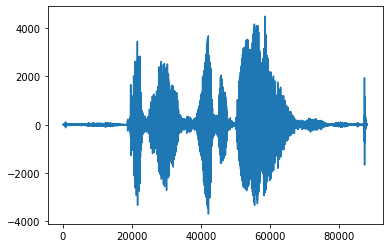

In [49]:
%matplotlib inline 
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav 
plt.plot(wav.read(trial_dict[41][2])[1])

In [41]:
# write out manifests 
import pickle 
from pathlib import Path
# get n files in output dir 

# manifest to expmt stim 
manifest = pandas.read_pickle('full_eval_trial_manifest_new_fnames_local_fnames.pdpkl')

# Name of sub directory to save experiment results - should match dir of trial dicts!
EXP_TYPE = "front_back_exp_v01" 

out_dir = Path(f'speaker_array_manifests/{EXP_TYPE}')
out_dir.mkdir(exist_ok=True, parents=True)
n_files = len(list(out_dir.glob('*manifest.pkl')))

np.random.seed(n_files) # change seed for each participant!!!! 

N_AZIM_BLOCKS = 10
N_ELEV_BLOCKS = 10
experiment, array_manifest, trial_dict = create_front_back_experiments(manifest,
                                                               num_azim_blocks=N_AZIM_BLOCKS,
                                                               num_elev_blocks=N_ELEV_BLOCKS)

print(f"{sum([len(experiment[key]) for key in experiment.keys()])} total trials")

PART_NAME = f"participant_{n_files+1:03d}"
print(PART_NAME)

with open(out_dir / f'{PART_NAME}_pilot_meta.pkl', 'wb') as f:
    pickle.dump(experiment, f)

with open(out_dir / f'{PART_NAME}_pilot_array_manifest.pkl', 'wb') as f:
    pickle.dump(array_manifest, f)

with open(out_dir / f'{PART_NAME}_pilot_trial_dict.pkl', 'wb') as f:
    pickle.dump(trial_dict, f)

# get target key list 
key_out_path = Path(f"expmt_keys")

word_key = [trial['target_word'] for block in experiment.values() for trial in block.values()]

# save as json 
import json 
with open(key_out_path / f"{EXP_TYPE}_{PART_NAME}_key.json", "w") as f:
    json.dump(word_key, f)

260 total trials
participant_002
